In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from src.process_data import process_data,load_data

In [2]:
df = process_data(fn='data/ripc_rel.csv',normalize='log2_fc',force=True)

loading.../home/elijahc/dev/ml_ripc/data/ripc_rel.csv
baseline shape: (73815, 30)

restructuring to longform...
(this may take a while)


/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [42]:
len(df)

22144500

In [6]:
by_mol_w = df[df.timepoint == 'C'].sort_values(by='Molecular Weight')

In [8]:
weights = by_mol_w['Molecular Weight'].values
print(weights.shape)

(2214450,)


In [9]:
weights.round(decimals=3).shape

(2214450,)

In [10]:
np.unique(weights.round(decimals=1))[:10]

array([65. , 66. , 66.1, 66.5, 67. , 67.5, 67.9, 68. , 68.1, 68.5])

(array([1.612e+03, 2.665e+03, 4.008e+03, 4.338e+03, 4.808e+03, 4.257e+03,
        3.509e+03, 3.374e+03, 2.737e+03, 2.859e+03, 2.758e+03, 2.622e+03,
        2.308e+03, 2.041e+03, 1.733e+03, 1.637e+03, 1.512e+03, 1.537e+03,
        1.276e+03, 1.327e+03, 1.278e+03, 1.266e+03, 1.082e+03, 1.246e+03,
        1.222e+03, 1.110e+03, 1.443e+03, 1.366e+03, 1.070e+03, 1.012e+03,
        1.198e+03, 6.940e+02, 9.690e+02, 7.280e+02, 6.900e+02, 4.370e+02,
        4.900e+02, 2.640e+02, 1.750e+02, 2.190e+02, 8.100e+01, 7.700e+01,
        8.300e+01, 6.600e+01, 7.900e+01, 9.000e+01, 6.400e+01, 6.800e+01,
        4.900e+01, 5.500e+01, 4.000e+01, 4.800e+01, 4.300e+01, 5.100e+01,
        4.900e+01, 6.700e+01, 6.700e+01, 5.300e+01, 3.500e+01, 3.500e+01,
        6.600e+01, 3.700e+01, 3.100e+01, 2.500e+01, 3.100e+01, 1.700e+01,
        1.600e+01, 2.700e+01, 3.800e+01, 3.400e+01, 3.100e+01, 2.500e+01,
        1.400e+01, 1.100e+01, 1.200e+01, 1.600e+01, 1.900e+01, 1.500e+01,
        1.500e+01, 7.000e+00, 1.200e+0

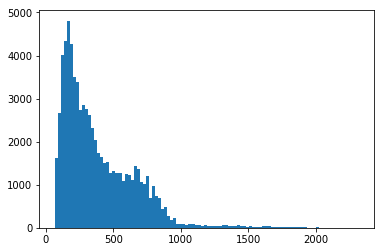

In [11]:
plt.hist(np.unique(weights),bins=100)

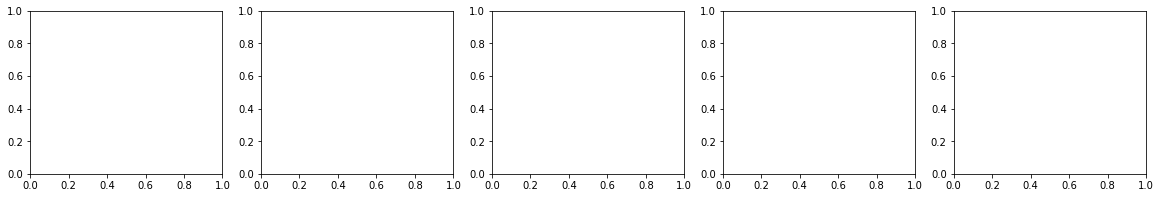

In [12]:
fig,axs = plt.subplots(1,5,figsize=(20,3))

In [ ]:
g = sns.scatterplot(x='value',y='Molecular Weight',data=df[df.timepoint=='D'],ax=axs[1])

In [ ]:
for ax,timepoint in zip(axs,['A','B','C','D','E','F','G','H','I','J']):
    sns.scatterplot(x='value',y='Molecular Weight',data=df[df.timepoint==timepoint],ax=ax)

In [13]:
fc_var = df.groupby(['pt','Molecular Weight'],sort=False).agg(['var'])['value'].reset_index()

In [14]:
fc_var['pt']

0           1
1           1
2           1
3           1
4           1
5           1
6           1
7           1
8           1
9           1
10          1
11          1
12          1
13          1
14          1
15          1
16          1
17          1
18          1
19          1
20          1
21          1
22          1
23          1
24          1
25          1
26          1
27          1
28          1
29          1
           ..
2179440    30
2179441    30
2179442    30
2179443    30
2179444    30
2179445    30
2179446    30
2179447    30
2179448    30
2179449    30
2179450    30
2179451    30
2179452    30
2179453    30
2179454    30
2179455    30
2179456    30
2179457    30
2179458    30
2179459    30
2179460    30
2179461    30
2179462    30
2179463    30
2179464    30
2179465    30
2179466    30
2179467    30
2179468    30
2179469    30
Name: pt, Length: 2179470, dtype: int64

In [ ]:
pd.DataFrame.quantile()

In [32]:
top_q = []
for pt_id in np.arange(30)+1:
    pt_df = fc_var.query('pt == '+str(pt_id))
    q75 = pt_df.quantile(q=0.75)['var']
    print(q75)
    top_q.extend(pt_df[pt_df['var'] >= q75]['Molecular Weight'].values.tolist())

0.4865946981926079
0.48185385756115817
0.5580123208271711
0.7186934477899585
0.5398438598022932
0.3973265921596441
0.43773249023753
0.4154260243860909
0.3841398208096559
0.4747100714965034
0.3995563108379969
0.5033686410305523
0.4410277939049443
0.42523047857720414
0.39884580803356734
0.6252867418008774
0.48031045543811335
0.5734216225549924
0.4918816682446095
0.580875804869538
0.45417185197522375
0.42672949425790313
0.4618931668261142
0.5289232117889178
0.5364946498801161
0.4718980212324068
0.4683109431194787
0.816760123302735
0.8613923939096413
0.5614981027041845


In [37]:
top_q_indexes = df['Molecular Weight'].isin(np.unique(np.array(top_q)))

In [ ]:
pd.DataFrame.so

In [54]:
df[top_q_indexes].groupby(['min'])['value'].describe()

,count,mean,std,min,25%,50%,75%,max
min,,,,,,,,
0,1653150.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1653150.0,-0.049633,1.080702,-15.246877,-0.433996,-0.033262,0.340233,14.632571
4,1653150.0,-0.044652,1.127554,-14.697979,-0.432703,-0.018257,0.358315,13.688148
6,1653150.0,-0.028886,1.149573,-14.381188,-0.437193,-0.012457,0.391047,14.951015
8,1653150.0,-0.049551,1.124201,-14.280814,-0.454960,-0.024719,0.365041,14.687547
10,1653150.0,-0.060376,1.130880,-15.192937,-0.442741,-0.021461,0.353618,13.980124
20,1653150.0,-0.091273,1.177060,-15.229102,-0.531536,-0.056746,0.346896,13.651907
30,1653150.0,-0.098816,1.207005,-14.764893,-0.536987,-0.045311,0.363073,13.889681
45,1653150.0,-0.128925,1.187559,-15.490631,-0.558996,-0.074157,0.318116,13.633087


In [36]:
print(np.array(top_q).shape)
print(np.unique(np.array(top_q)).shape)

(544890,)
(54047,)


In [ ]:
sns.scatterplot(x='var',y='Molecular Weight',data=fc_var)

In [ ]:
fc_var_hi = fc_var[fc_var['var']>=10]
print(len(fc_var_hi))
sns.scatterplot(x='var',y='Molecular Weight',data=fc_var_hi)

In [ ]:
plt.hist(fc_var.values)

In [ ]:
fc_var.shape